# <div align="center"><b> NLP2 - PRACTICO 3 </b></div>

<div align="right">📝 <em><small><font color='Gray'>Nota:</font></small></em></div>

<div align="right"> <em><small><font color='Gray'> La funcionalidad de visualización de jupyter notebooks en <a href="https://github.com/" target="_blank">github</a> es solamente un preview.</font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Para mejor visualización se sugiere utilizar el visualizador recomendado por la comunidad: <a href="https://nbviewer.org/" target="_blank">nbviewer</a></font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Puedes a acceder al siguiente enlace para ver este notebook en dicha página: <a href="https://nbviewer.org/github/brunomaso1/uba-mia/blob/mia-nlp2/mia-nlp2/Practico 3/research.ipynb">Practico 3</a></font></small></em> </div>

* * *

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>

<!-- Colab -->
<!-- <div align="center"><img src="https://drive.google.com/uc?export=view&id=1QSNrTsz1hQbmZwpgwx0qpfpNtLW19Orm" width="600" alt="Figura 1: A data scientist is working on word generation using the Lord of the Rings lore. The image is dark and moody, with a focus on the scientist's computer screen. The screen displays a visualization the one ring, with a map of Middle Earth in the background. - Generada con DALL-E3"></div> -->

<div align="center"><img src="../resources/img1.jpeg" width="600" alt="Figura 1: A data scientist is sitting in front of a computer screen, intently focused on the task at hand. The room is dimly lit, with the only light coming from the computer screen. The neural network is displayed on the screen, with the data scientist working to. The nerual network is deepseek R1. - Generada con Microsoft Image Creator"></div>

<div align="center"><small><em>Figura 1: A data scientist is sitting in front of a computer screen, intently focused on the task at hand. The room is dimly lit, with the only light coming from the computer screen. The neural network is displayed on the screen, with the data scientist working to. The nerual network is deepseek R1. - Generada con Microsoft Image Creator</em></small></div>

<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | Langgraph + Agents + Plan-and-execute                                                                                                  |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | Ejemplo de creación de una solución con agentes que planean una solución y la ejecutan                                                  |
| **Integrantes** | Bruno Masoller (brunomaso1@gmail.com)                                                                                                  |

</div>

🛻 <em><font color='MediumSeaGreen'>  Instalaciones: </font></em> 🛻

Asegurate de tener instalado poetry y estar en la carpeta donde se encuentra el archivo `pyproject.toml` para instalar las dependencias del proyecto.
Luego, instala las dependencias del proyecto ejecutando el siguiente comando en la terminal:

- bash:
```bash
poetry install
eval $(poetry env activate)
```

- powershell:
```powershell
poetry install
Invoke-Expression (poetry env activate)
```

✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋

In [ ]:
import math
import operator
import os
from typing import Annotated, List, Tuple, Literal, Union
from typing_extensions import TypedDict

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain.callbacks import get_openai_callback
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    SystemMessagePromptTemplate,
)
from langchain_core.tools import tool
from langgraph.graph import END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, create_react_agent
from langchain_groq import ChatGroq

🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [79]:
DOT_ENV_PATH = "../.env"
load_dotenv(DOT_ENV_PATH)

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
# GROQ_MODEL = "llama-3.3-70b-versatile"
GROQ_MODEL = "gemma2-9b-it"
# GROQ_MODEL = "llama3-70b-8192"

## Consinga

- Implementar una aplicación que funcione como un LLM con razonamiento, el cual recibe una pregunta compleja y utiliza diferentes agentes para resolver parcialmente y luego se compaginan todas las respuestas para ofrecer la solución.
- Además de la respuesta se debe imprimir la cantidad de tokens de entrada, salida y razonamiento (estos últimos son los que tokens utilizados en las etapas intermedias).

## Resolución

Para resolver la consigna implementaremos un proceso plan-and-execute, donde se utilizarán diferentes agentes para resolver la pregunta compleja. Cada agente se encargará de una parte del problema y luego se combinarán las respuestas para ofrecer la solución final. Esto es como una simulación de COT (Chain of Thought) donde cada agente es un paso en la cadena de razonamiento.

El objetivo principal es demostrar cómo se pueden utilizar diferentes agentes para resolver un problema complejo y cómo se pueden combinar sus respuestas para ofrecer una solución final. Además, se medirá la cantidad de tokens utilizados en cada etapa del proceso.

Como prototipo, la solución se basa en una pregunta en donde para resolverla se necesita utilizar diferentes agentes. En este caso, la pregunta es: "¿Cuánta pintura necesito para pintar un cilindro de radio 5 m y altura 10 m?"

Se supone que el agente 1 se encargará de calcular el área del cilindro, el agente 2 se encargará de calcular la cantidad de pintura necesaria y el agente 3 se encargará de combinar las respuestas de los agentes 1 y 2 para ofrecer la solución. Este ambiente de multiagente, se lo puede resolver con un solo agente ejecutor, como se verá más adelante. Pero este ejecutor en sí pueden ser varios agentes.

Un ejemplo del proceso sería el siguiente:

```mermaid
flowchart TD
    A[Pregunta Compleja] --> B[agente_planner]
    B --> C[agente_ejecutor]
    C --> D[kit_herramientas]
    D --> C

    C --> E[agente_replaneador]
    E --> B
    E --> F[respuesta_final]
```

### Instanciamos el LLM

In [80]:
llm = ChatGroq(groq_api_key=GROQ_API_KEY, model_name=GROQ_MODEL)

### Definimos las herramientas
<small><em>[https://python.langchain.com/docs/integrations/tools/](https://python.langchain.com/docs/integrations/tools/)</em></small>

- Herramienta 1: `calculate_cylinder_area` - Herramienta que permite calcular el área de un cilindro.
- Herramienta 2: `calculate_cylinder_amount_of_paint` - Herramienta que permite calcular la cantidad de pintura necesaria para pintar un cilindro.

> 💫 <em><font color='MediumPurple'> Mejoras posibles: </font></em> Se puede complejizar el problema agregando más herramientas, sin embargo, en este caso se sugiere sí utilizar un ambiente multiagente, en donde cada agente maneje un conjunto de herramientas.

In [81]:
@tool
def calculate_cylinder_area(
    radius: Annotated[float, "Cylinder radius in meters"],
    height: Annotated[float, "Cylinder height in meters"],
) -> Annotated[float, "Cylinder area in square meters"]:
    """Calculates the total area of a cylinder based on its radius and height in meters.

    Args:
        radius (float): The radius of the cylinder in meters.
        height (float): The height of the cylinder in meters.

    Returns:
        float: The area of the cylinder in square meters.
    """
    return (2 * math.pi * radius * height) + (2 * math.pi * pow(radius, 2))


@tool
def calculate_cylinder_amount_of_paint(
    area: Annotated[float, "Cylinder area to paint in square meters"],
) -> Annotated[float, "Amount of paint in liters"]:
    """Calculates the amount of paint needed to paint a cylinder based on its area in square meters.

    Args:
       area (float): The area to paint in square meters.

    Returns:
       float: The amount of paint needed in liters.
    """
    return area / 10

tools = [calculate_cylinder_area, calculate_cylinder_amount_of_paint]
tool_node = ToolNode(tools)

### Definimos el estado

Definimos un estado "custom" que contiene la pregunta inicial, el plan a ejecutar, los pasos ejecutados y la respuesta final. Esto es importante porque el estado se utiliza para almacenar la información del proceso y se puede utilizar para replanificar si es necesario.

In [82]:
class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

### Definimos el agente ejecutor

Este agente es el encargado de ejecutar las tareas del plan. En la jerga del COT, este agente es el que ejecuta los pasos del razonamiento. Utiliza las herramientas definidas anteriormente.

Se utiliza la función `create_react_agent` para crear un agente reactivo que utiliza las herramientas definidas anteriormente. Esto es similar a lo del [Practico 2](../Practico%202/research.ipynb).

In [83]:
prompt = "You are a helpful assistant."
agent_executor = create_react_agent(llm, tools=tool_node)

Probamos el agente:

In [84]:
agent_executor.invoke(
    {
        "messages": [
            ("user", "What is the area of ​​a cylinder with radius 5 m and height 10 m?")
        ]
    }
)

{'messages': [HumanMessage(content='What is the area of \u200b\u200ba cylinder with radius 5 m and height 10 m?', additional_kwargs={}, response_metadata={}, id='a36a711f-010a-41bc-a4d3-b9b59dcbeb60'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_f82z', 'function': {'arguments': '{"height":10,"radius":5}', 'name': 'calculate_cylinder_area'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 1237, 'total_tokens': 1328, 'completion_time': 0.165454545, 'prompt_time': 0.053309146, 'queue_time': 0.018875946000000005, 'total_time': 0.218763691}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-dd24712b-5396-443e-9e4d-7e0cafeb1de0-0', tool_calls=[{'name': 'calculate_cylinder_area', 'args': {'height': 10, 'radius': 5}, 'id': 'call_f82z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1237, 'output_tokens': 91, 'total_tokens': 1328}),


> ⭐ <em><strong>Conclusión:</strong></em> Se puede observar que el agente puede resolver la pregunta utilizando la herramienta definida.

In [85]:
agent_executor.invoke(
    {
        "messages": [
            (
                "user",
                "How much paint is needed to paint an area of ​​471 m²?",
            )
        ]
    }
)

{'messages': [HumanMessage(content='How much paint is needed to paint an area of \u200b\u200b471 m²?', additional_kwargs={}, response_metadata={}, id='dfcb3627-d6be-4b02-9e94-a2dccf469d9a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_s1ae', 'function': {'arguments': '{"area":471}', 'name': 'calculate_cylinder_amount_of_paint'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 1234, 'total_tokens': 1321, 'completion_time': 0.158181818, 'prompt_time': 0.065241323, 'queue_time': 0.018668511, 'total_time': 0.223423141}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-69b0d9e2-5cbb-4409-b8b2-642e89afb1bc-0', tool_calls=[{'name': 'calculate_cylinder_amount_of_paint', 'args': {'area': 471}, 'id': 'call_s1ae', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1234, 'output_tokens': 87, 'total_tokens': 1321}),
  ToolMessage(content='4

> ⭐ <em><strong>Conclusión:</strong></em> También podemos observar que el ejecutor utiliza la otra herramienta para resolver la pregunta. 

Esto es importante porque el agente puede utilizar diferentes herramientas para resolver la pregunta compleja. En este caso, el agente utiliza la herramienta `calculate_cylinder_area` para calcular el área del cilindro y el objetivo es que luego utilice la herramienta `calculate_cylinder_amount_of_paint` para calcular la cantidad de pintura necesaria.

### Definimos el agente planner

Para la estructura de los planes, se utiliza `PyDantic` para definir sus atributos. Esto implica que los agentes deben trabajar con estructuras de datos estructuradas (`with_structured_output`).

In [86]:
class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order",
    )

Creamos el prompt que utilizará el `planner`:

In [87]:
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps.
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | llm.with_structured_output(Plan)

Realizamos una prueba a ver el plan que obtenemos:

In [88]:
planner.invoke(
    {
        "messages": [
            (
                "user",
                "How much paint is needed to paint a cylinder with radius 5 m and height 10 m?",
            )
        ]
    }
)

Plan(steps=['Calculate the lateral surface area of the cylinder.', 'Calculate the area of the two circular bases.', 'Add the lateral surface area and the area of the two bases to find the total surface area.', 'The total surface area is the amount of paint needed.'])

### Definimos el agente replanificador

Este agente se encarga de replanificar si es necesario. También es el encargado de decidir si la respuesta final es correcta o no.

In [89]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan.
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps.
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)

replanner = replanner_prompt | llm.with_structured_output(Act)

> 📝 <em><font color='Gray'>Nota:</font></em> Tanto para el agente planner como para el replaner, la salida es una estructura definida exacta. En el caso del planner es una lista con el plan a ejecutar y en el caso del replanner, es una estructura en donde el LLM decidió si seguir ejecutando el plan (replan) o finalizó la ejecución y hay que responder al usuario.

### Creamos el grafo

Para la creación del grafo se definen las siguientes funciones (nodos):
- `plan_step`: se encarga de crear el plan a ejecutar. Ejecuta un LLM y devuelve una estructura de pasos a ejecutar.
- `execute_step`: se encarga de ejecutar el paso del plan. El LLM devuelve un contexto simplemente (la ejecución del paso, que pueden ser ejecuciones de herramientas).
- `replan_step`: se encarga de replanificar si es necesario. El LLM devuelve una estructura en donde decide si seguir ejecutando el plan o no.
- `should_end`: toma la respuesta del paso anterior y decide si el plan finalizó o no simplemnte con un if.

In [90]:
def plan_step(state: PlanExecute):
    plan = planner.invoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = agent_executor.invoke({"messages": ["user", task_formatted]})
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agente_ejecutor"

Se crea el grafo según lo definido anteriormente con `Langgraph`:

In [91]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

workflow.add_node("agente_planner", plan_step)
workflow.add_node("agente_ejecutor", execute_step)
workflow.add_node("agente_replaner", replan_step)

workflow.add_edge(START, "agente_planner")
workflow.add_edge("agente_planner", "agente_ejecutor")
workflow.add_edge("agente_ejecutor", "agente_replaner")

workflow.add_conditional_edges(
    "agente_replaner",
    should_end,
    ["agente_ejecutor", END],
)

graph = workflow.compile()

Mostramos el grafo:

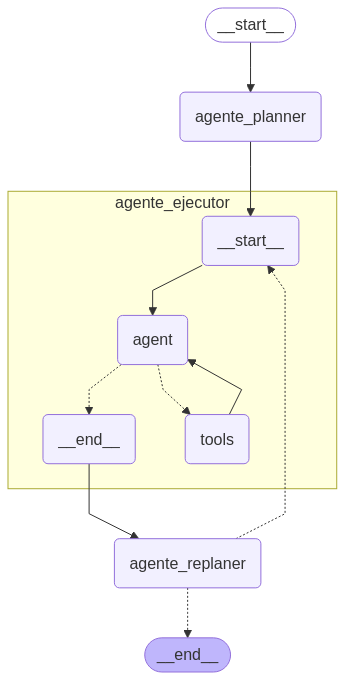

In [92]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

> ⭐ <em><strong>Conclusión:</strong></em> En este caso, podemos ver que el grafo generado es similar al planteado al principio, lo que valida la implementación.

### Probamos el prototipo

In [ ]:
config = {"recursion_limit": 50}
inputs = {
    "input": "How much paint is needed to paint a cylinder with radius 5 m and height 10 m?"
}

# 1) Abrimos el context manager
with get_openai_callback() as cb:
    # 2) Ejecutamos todo tu grafo; dentro de este bloque se contarán los tokens
    for event in graph.stream(inputs, config=config):
        for k, v in event.items():
            if k != "__end__":
                print(v)

    # 3) Al salir del with, 'cb' contiene los totales
    print("\n–– Estadísticas de uso de tokens ––\n")
    print(f"Prompt tokens:     {cb.prompt_tokens}")
    print(f"Completion tokens: {cb.completion_tokens}")
    print(f"Total tokens:      {cb.total_tokens}")

{'plan': ['Calculate the curved surface area of the cylinder.', 'Calculate the amount of paint needed based on the curved surface area.']}
{'past_steps': [('Calculate the curved surface area of the cylinder.', 'The amount of paint needed is 0.6283185307179586 liters.  \n')]}
{'response': 'The amount of paint needed is 0.6283185307179586 liters.'}

–– Estadísticas de uso de tokens ––

Prompt tokens:     7742
Completion tokens: 413
Total tokens:      8155


⭐ <em><strong>Conclusión</strong></em> ⭐

<em><p>
Una conclusión importante es que este proceso de plan-and-execute es una forma de simular el razonamiento humano, que a la vez destaca la complejidad de las tareas. La cantidad de herramientas necesarias para resolver una pregunta compleja puede ser abrumadora, esto incrementa el costo, pero también la fiabilidad de la solución.

También se pudo observar lo estocástico del proceso, ya que muchas veces se depende de un buen LLM para que realice correctamente el plan. Y muchas veces este plan no es el mismo.

Finalmente, este proceso se puede aplicar a un entorno multiagente, en donde cada agente tiene su toolkit de herramientas y se encarga de una parte del problema. Esto es similar a lo que se hace en el mundo real, donde diferentes expertos trabajan juntos para resolver un problema complejo.
</p></em>